# Exercise 04 - Local approximations

The volume of a four-bar truss should be minimized under the displacement constraint $\delta \le \delta_0$. There is a force $P>0$ acting along the direction of bar 4. All bars have identical lengths $l$ and identical Young's moduli $E$. The modifiable structural variables are the cross sectional areas $A_1=A_4$ and $A_2=A_3$. We define $A_0 = Pl / (10\delta_0E)$ and constrain the variables $0.2A_0 \le A_j \le 2.5 A_0$. Then we can use dimensionless design variables $a_j=A_j/A_0 \in [0.2, 2.5]$.


![Four bar truss](https://meyer-nils.github.io/structural_optimization/figures/four_bar_truss.png)


Credits: Peter W. Christensen and Anders Klarbring. *An Introduction to Structural Optimization.* Springer Netherlands, 2008.

In [1]:
from math import sqrt

import matplotlib.pyplot as plt
import torch
from torchfem.utils import plot_contours

## Task 1 - Defining the constrained optimization problem

a) Compute the objective function $f(\mathbf{a})$ that should be minimized and define it as Python function that accepts inputs tensors of the shape [..., 2].


> The total volume is 
> $$ V = l A_1 + l A_2 + l A_3 + l A_4 = 2l A_1 + 2l A_2.$$
> Substituting $A_j = a_j A_0$ gives 
> $$ V = 2l A_0 (a_1 + a_2).$$
> The factor in front of the brackets is a positive constant, which we can neglect for the optimization task itself. Hence, we can simplify the function to
> $$f(\mathbf{a}) = a_1 + a_2.$$

In [2]:
def f(a):
    return a[..., 0] + a[..., 1]

b) Compute the constraint function $g(\mathbf{a})$ for $\delta_0=0.1$ and define it as Python function that accepts inputs tensors of the shape [..., 2].

> A free body diagram of the free node gives 
> $$ - \frac{4}{5} P_1 - \frac{3}{5} P_2 + \frac{3}{5}P_3 + \frac{4}{5} P_4 + \frac{4}{5} P = 0 $$
> $$ \frac{3}{5} P_1 + \frac{4}{5} P_2 + \frac{4}{5}P_3 + \frac{3}{5} P_4 + \frac{3}{5} P = 0 $$
> In addition, the kinematics give us the following relation for the elongation of each bar $\Delta u_j$:
> $$ \frac{4}{5} u_1 - \frac{3}{5} u_2 = \Delta u_1$$
> $$ \frac{3}{5} u_1 - \frac{4}{5} u_2 = \Delta u_2 $$
> $$ -\frac{3}{5} u_1 - \frac{4}{5} u_2 = \Delta u_3 $$
> $$ -\frac{4}{5} u_1 - \frac{3}{5} u_2 = \Delta u_4 $$
> Substituting the displacements into the elastic relations and using $A_1=A_4$ and $A_2=A_3$ gives
> $$P_1 = \frac{E}{5l} A_1 (4u_1-3u_2)$$
> $$P_2 = \frac{E}{5l} A_2 (3u_1-4u_2)$$
> $$P_3 = \frac{E}{5l} A_2 (-3u_1-4u_2)$$
> $$P_4 = \frac{E}{5l} A_1 (-4u_1-3u_2)$$
> Substituting these expression into the first two equations of the free body diagram yields
> $$u_1(32A_1+18A_2)=20 \frac{Pl}{E}$$
> $$u_2(18A_1+32A_2)=15 \frac{Pl}{E}$$
> which can be solved for 
> $$u_1 = \frac{10}{16a_1+9a_2}$$
> $$u_2 = \frac{7.5}{9a_1+16a_2}$$
> using the definition of $A_0$. Finally, we can compute the displacement 
> $$\delta = \Delta u_1 = \frac{4}{5} u_1 - \frac{3}{5} u_2 = \frac{8}{16a_1+9a_2} - \frac{4.5}{9a_1+16a_2}$$
> and define 
> $$g(\mathbf{a}) = \frac{8}{16a_1+9a_2} - \frac{4.5}{9a_1+16a_2} - 0.1.$$




In [3]:
def g(a):
    return (
        8 / (16 * a[..., 0] + 9 * a[..., 1])
        - 4.5 / (9 * a[..., 0] + 16 * a[..., 1])
        - 0.1
    )

c) Summarize the optimization problem statement with all constraints. 

> $$\min_\mathbf{a} f(\mathbf{a}) = a_1 + a_2$$
> $$\text{s.t.} \quad g(\mathbf{a}) = \frac{8}{16a_1+9a_2} - \frac{4.5}{9a_1+16a_2} - 0.1 \le 0$$
> $$\quad a_1 \in [0.2, 2.5], a_2 \in [0.2, 2.5]$$


## Task 2 - CONLIN

a) Implement a function named `CONLIN(func, a_k)` that computes a CONLIN approximation of the function `func` at position `a_k`. `CONLIN` should return an approximation function that can be evaluated at any point `a`.


In [4]:
def CONLIN(func, a_k):
    a_lin = a_k.clone().requires_grad_()
    gradients = torch.autograd.grad(func(a_lin), a_lin)[0]

    def approximation(a):
        res = func(a_k)
        for j, grad in enumerate(gradients):
            if grad < 0.0:
                Gamma = a_k[j] / a[j]
            else:
                Gamma = 1.0
            res += grad * Gamma * (a[j] - a_k[j])
        return res

    return approximation

b) Test your CONLIN approximation with the following code. Does the plot match your expectations?

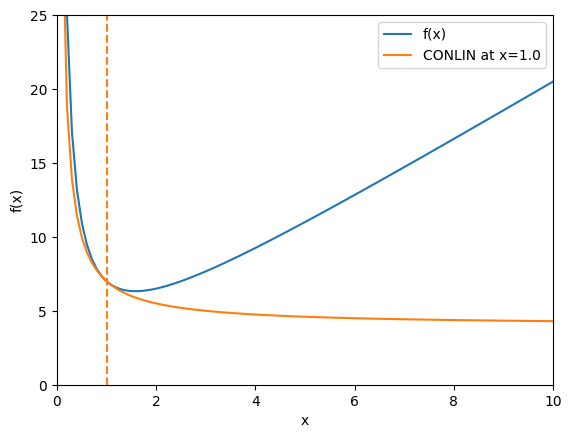

In [5]:
def test_function(x):
    return 5.0 / x + 2.0 * x


x = torch.linspace(0, 10, 100)[:, None]
x_0 = torch.tensor([1.0])
test_approximation = CONLIN(test_function, x_0)
plt.plot(x, test_function(x), label="f(x)")
plt.plot(x, [test_approximation(x_i) for x_i in x], label=f"CONLIN at x={x_0.item()}")
plt.axvline(x_0, color="tab:orange", linestyle="--")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim(0, 10)
plt.ylim(0, 25)
plt.show()

c) Solve the problem with sequential CONLIN approximations starting from $\mathbf{a}^0 = (2,1)^\top$ with the dual method. Record all intermediate points $\mathbf{a}^0, \mathbf{a}^1, \mathbf{a}^2, ...$ in a list called `a` for later plotting.

You will need to compute minima and maxima in this procedure, hence you are given the `box_constrained_decent` method from the previous excercise to perform these operations. The method is slightly modified:
- It takes extra arguments that can be passed to the function, e.g. by `box_constrained_decent(..., mu=1.0)` 
- It returns only the final result and not all intermediate steps

In [6]:
def box_constrained_decent(
    func, x_init, x_lower, x_upper, eta=0.1, max_iter=100, **extra_args
):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        grad = torch.autograd.grad(func(x, **extra_args), x)[0]
        x = x - eta * grad
        x = torch.clamp(x, x_lower, x_upper)
    return x

In [7]:
# Define the initial values, lower bound, and upper bound of "a"
a_0 = torch.tensor([2.0, 1.0], requires_grad=True)
a_lower = torch.tensor([0.2, 0.2])
a_upper = torch.tensor([2.5, 2.5])

# Define the initial value, lower bound, and upper bound of "mu"
mu_0 = torch.tensor([10.0])
mu_lower = torch.tensor([1e-10])
mu_upper = None

# Save intermediate values
a = [a_0]

for k in range(3):
    # Compute the current approximation function:
    g_tilde = CONLIN(g, a[k])

    # Define the Lagrangian
    def lagrangian(a, mu):
        return f(a) + mu * g_tilde(a)

    # Define a_star by minimizing the Lagrangian w. r. t. a numerically
    def a_star(mu):
        return box_constrained_decent(lagrangian, a[k], a_lower, a_upper, mu=mu)

    # Define (-1 times) the dual function
    def dual_function(mu):
        return -lagrangian(a_star(mu), mu)

    # Compute the maximum of the dual function
    mu_k = box_constrained_decent(dual_function, mu_0, mu_lower, mu_upper, eta=10.0)

    # Compute the next a_k from mu_k and append it to a
    a.append(a_star(mu_k))

d) Test your optimization with the following code. Does the plot match your expectations?

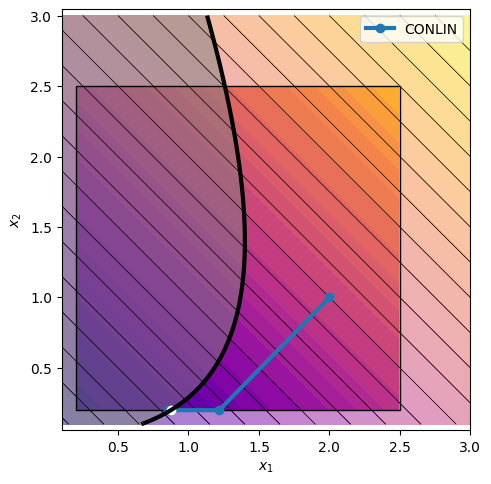

In [8]:
# Plotting domain
a_1 = torch.linspace(0.1, 3.0, 200)
a_2 = torch.linspace(0.1, 3.0, 200)
a_grid = torch.stack(torch.meshgrid(a_1, a_2, indexing="xy"), dim=2)

# Make a plot
plot_contours(
    a_grid,
    f(a_grid),
    paths={"CONLIN": a},
    box=[a_lower, a_upper],
    opti=[a[-1][0], a[-1][1]],
    figsize=(5, 5),
)
plt.contour(a_1, a_2, g(a_grid), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a_grid), [0, 1], colors="gray", alpha=0.5)
plt.show()

e) This implementation is relatively slow. How could it be accelerated?

> We could compute gradients analytically. This is an example giving the same result, but much faster. 
>
> The approximated function is separable, i.e. we can stat the following for a stationary point
> $$ \frac{\partial \mathcal{L}}{\partial a_j} = 
> \begin{cases}
>       1 + \mu \frac{\partial g}{\partial a_j}(\mathbf{a}^k) &\quad \text{if} \frac{\partial g}{\partial a_j}(\mathbf{a}^k) \ge 0\\
>       1 + \mu \frac{\partial g}{\partial a_j}(\mathbf{a}^k) \left(\frac{a_j^k}{a_j}\right)^2 &\quad \text{else}
> \end{cases}
> $$
> If this should equal 0, we can solve it for the optimum $a^*_j$ as 
> $$ a^*_j = 
> \begin{cases}
>       a_j^l &\quad \text{if} \frac{\partial g}{\partial a_j}(\mathbf{a}^k) \ge 0\\
>       \sqrt{-\mu \frac{\partial g}{\partial a_j}(\mathbf{a}^k)\left(a_j^k\right)^2} &\quad \text{else}
> \end{cases}
> $$
> where we use the fact that a linear approximation with a positive slope will have its minimum at the lowest value of $a$, i.e. $a_j^l$.

In [9]:
# Save intermediate values
a = [a_0]

for k in range(3):
    # Compute the current approximation function:
    g_tilde = CONLIN(g, a[k])

    # Define the Lagrangian
    def lagrangian(a, mu):
        return f(a) + mu * g_tilde(a)

    # Define a_star by minimizing the Lagrangian w. r. t. a analytically
    a_lin = a[k].clone().requires_grad_()
    gradients = torch.autograd.grad(g(a_lin), a_lin)[0]

    def a_star(mu):
        a_hat = torch.zeros_like(gradients)
        pg = gradients >= 0
        ng = gradients < 0
        a_hat[pg] = a_lower[pg]
        a_hat[ng] = torch.sqrt(-mu * gradients[ng] * a[k][ng] ** 2)
        return torch.clamp(a_hat, a_lower, a_upper)

    # Define (-1 times) the dual function
    def dual_function(mu):
        return -lagrangian(a_star(mu), mu)

    # Compute the maximum of the dual function
    mu_k = box_constrained_decent(dual_function, mu_0, mu_lower, mu_upper, eta=10.0)

    # Compute the next a_k from mu_k and append it to a
    a.append(a_star(mu_k))

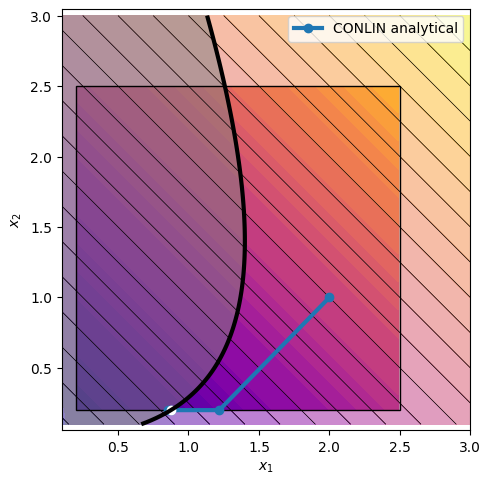

In [10]:
# Make a plot
plot_contours(
    a_grid,
    f(a_grid),
    paths={"CONLIN analytical": a},
    box=[a_lower, a_upper],
    opti=[a[-1][0], a[-1][1]],
    figsize=(5, 5),
)
plt.contour(a_1, a_2, g(a_grid), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a_grid), [0, 1], colors="gray", alpha=0.5)
plt.show()

## Task 3 - MMA

a) Implement a function named `MMA(func, a_k, L_k, U_k)` that computes a MMA approximation of the function `func` at position `a_k` with lower asymptotes `L_k` and uper asymtotes `U_k`. `MMA` should return an approximation function that can be evaluated at any point `a`.

In [11]:
def MMA(func, a_k, L_k, U_k):
    a_lin = a_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(a_lin), a_lin)[0]
    pg = grads >= 0
    ng = grads < 0.0

    def approximation(a):
        p = torch.zeros_like(grads)
        p[pg] = (U_k[pg] - a_k[pg]) ** 2 * grads[pg]
        q = torch.zeros_like(grads)
        q[ng] = -((a_k[ng] - L_k[ng]) ** 2) * grads[ng]
        return (
            func(a_k)
            - torch.sum(p / (U_k - a_k) + q / (a_k - L_k))
            + torch.sum(p / (U_k - a) + q / (a - L_k))
        )

    return approximation

b) Test your MMA approximation with the following code. Does the plot match your expectations?

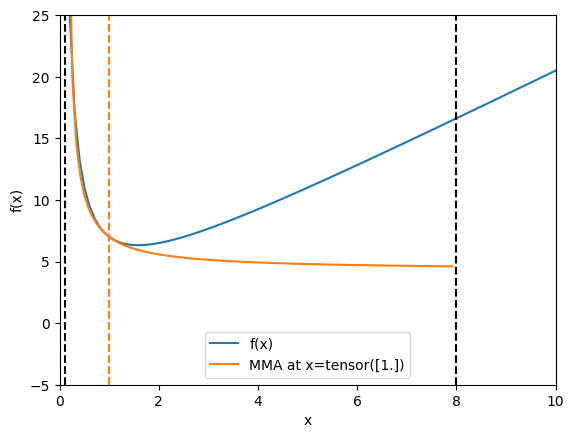

In [12]:
def test_function(x):
    return 5.0 / x + 2.0 * x


x = torch.linspace(0, 10, 100)[:, None]
x_0 = torch.tensor([1.0])
L_0 = torch.tensor([0.1])
U_0 = torch.tensor([8.0])
x_test = torch.linspace(L_0.item(), U_0.item(), 100)[:, None]
test_approximation = MMA(test_function, x_0, L_0, U_0)
plt.plot(x, test_function(x), label="f(x)")
plt.plot(x_test, [test_approximation(x_i) for x_i in x_test], label=f"MMA at x={x_0}")
plt.axvline(x_0, color="tab:orange", linestyle="--")
plt.axvline(L_0, color="black", linestyle="--")
plt.axvline(U_0, color="black", linestyle="--")
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
plt.xlim(0, 10)
plt.ylim(-5, 25)
plt.show()

c) Solve the problem with sequential MMA approximations starting from $\mathbf{a}^0 = (2,1)^\top$ with the dual method. Record all intermediate points $\mathbf{a}^0, \mathbf{a}^1, \mathbf{a}^2, ...$ in a list called `a` for the asymptote updates and later plotting.

In [13]:
# Define the initial values, lower bound, and upper bound of "a"
a_0 = torch.tensor([2.0, 1.0], requires_grad=True)
a_lower = torch.tensor([0.2, 0.2])
a_upper = torch.tensor([2.5, 2.5])

# Define the initial value, lower bound, and upper bound of "mu"
mu_0 = torch.tensor([10.0])
mu_lower = torch.tensor([1e-10])
mu_upper = None

# Save intermediate values
a = [a_0]
L = []
U = []

# Define factor s for shrinkage and growth of asymptotes
s = 0.7

for k in range(5):
    # Update asymptotes with heuristic procedure
    if k <= 1:
        L.append(a[k] - s * (a_upper - a_lower))
        U.append(a[k] + s * (a_upper - a_lower))
    else:
        L_k = torch.zeros_like(L[k - 1])
        U_k = torch.zeros_like(U[k - 1])
        # Shrink all oscillating asymptotes
        osci = (a[k] - a[k - 1]) * (a[k - 1] - a[k - 2]) < 0.0
        L_k[osci] = a[k][osci] - s * (a[k - 1][osci] - L[k - 1][osci])
        U_k[osci] = a[k][osci] + s * (U[k - 1][osci] - a[k - 1][osci])
        # Expand all non-oscillating asymptotes
        L_k[~osci] = a[k][~osci] - 1.0 / sqrt(s) * (a[k - 1][~osci] - L[k - 1][~osci])
        U_k[~osci] = a[k][~osci] + 1.0 / sqrt(s) * (U[k - 1][~osci] - a[k - 1][~osci])
        L.append(L_k)
        U.append(U_k)

    # Compute lower move limit in this step
    a_lower_k = torch.max(a_lower, 0.9 * L[k] + 0.1 * a[k])
    a_upper_k = torch.min(a_upper, 0.9 * U[k] + 0.1 * a[k])

    # Compute the current approximation function:
    g_tilde = MMA(g, a[k], L[k], U[k])

    # Define the Lagrangian
    def lagrangian(a, mu):
        return f(a) + mu * g_tilde(a)

    # Define a_star by minimizing the Lagrangian w. r. t. a
    def a_star(mu):
        return box_constrained_decent(lagrangian, a[k], a_lower_k, a_upper_k, mu=mu)

    # Define (-1 times) the dual function
    def dual_function(mu):
        return -lagrangian(a_star(mu), mu)

    # Compute the maximum of the dual function
    mu_k = box_constrained_decent(dual_function, mu_0, mu_lower, mu_upper, eta=10.0)

    # Compute the next a_k from mu_k and append it to a
    a.append(a_star(mu_k))

d) Test your optimization with the following code. Does the plot match your expectations?

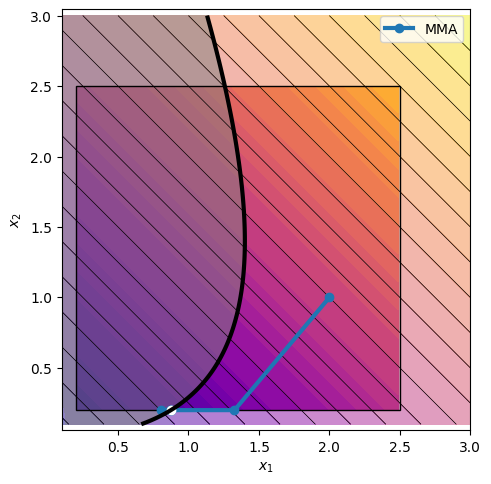

In [14]:
# Plotting domain
a_1 = torch.linspace(0.1, 3.0, 200)
a_2 = torch.linspace(0.1, 3.0, 200)
a_grid = torch.stack(torch.meshgrid(a_1, a_2, indexing="xy"), dim=2)

# Make a plot
plot_contours(
    a_grid,
    f(a_grid),
    paths={"MMA": a},
    box=[a_lower, a_upper],
    opti=[a[-1][0], a[-1][1]],
    figsize=(5, 5),
)
plt.contour(a_1, a_2, g(a_grid), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a_grid), [0, 1], colors="gray", alpha=0.5)
plt.show()

e) This implementation is relatively slow. How could it be accelerated?

> We could compute gradients analytically. This is an example giving the same result, but much faster. 
>
> The approximated function is separable, i.e. we can formulate the stationary condition as
> $$ \frac{\partial \mathcal{L}}{\partial a_j} = 
> \begin{cases}
>       1 + \mu \left(\frac{U_j^k-a_j^k}{U_j^k-a_j}\right)^2\frac{\partial g}{\partial a_j}(\mathbf{a}^k) &\quad \text{if} \frac{\partial g}{\partial a_j}(\mathbf{a}^k) \ge 0\\
>       1 + \mu \left(\frac{a_j^k-L_j^k}{a_j-L_j^k}\right)^2\frac{\partial g}{\partial a_j}(\mathbf{a}^k) &\quad \text{else}
> \end{cases}
> $$
> If this should equal 0, we can solve it for $a^*_j$ as 
> $$ a^*_j = 
> \begin{cases}
>       a_j^l &\quad \text{if} \frac{\partial g}{\partial a_j}(\mathbf{a}^k) \ge 0\\
>       L_j^k+\sqrt{-\mu(a_j^k-L_j^k)^2\frac{\partial g}{\partial a_j}(\mathbf{a}^k)} &\quad \text{else}
> \end{cases}
> $$
> where we use the fact that a linear approximation with a positive slope will have its minimum at the lowest value of $a$, i.e. $a_j^l$.

In [15]:
# Save intermediate values
a = [a_0]
L = []
U = []

# Define factor s for shrinkage and growth of asymptotes
s = 0.7

for k in range(5):
    # Update asymptotes with heuristic procedure
    if k <= 1:
        L.append(a[k] - s * (a_upper - a_lower))
        U.append(a[k] + s * (a_upper - a_lower))
    else:
        L_k = torch.zeros_like(L[k - 1])
        U_k = torch.zeros_like(U[k - 1])
        # Shrink oscillating asymptotes
        osci = (a[k] - a[k - 1]) * (a[k - 1] - a[k - 2]) < 0.0
        L_k[osci] = a[k][osci] - s * (a[k - 1][osci] - L[k - 1][osci])
        U_k[osci] = a[k][osci] + s * (U[k - 1][osci] - a[k - 1][osci])
        # Expand non-oscillating asymptotes
        L_k[~osci] = a[k][~osci] - 1.0 / sqrt(s) * (a[k - 1][~osci] - L[k - 1][~osci])
        U_k[~osci] = a[k][~osci] + 1.0 / sqrt(s) * (U[k - 1][~osci] - a[k - 1][~osci])
        L.append(L_k)
        U.append(U_k)

    # Compute lower move limit in this step
    a_lower_k = torch.max(a_lower, 0.9 * L[k] + 0.1 * a[k])
    a_upper_k = torch.min(a_upper, 0.9 * U[k] + 0.1 * a[k])

    # Compute the current approximation function:
    g_tilde = MMA(g, a[k], L[k], U[k])

    # Define the Lagrangian
    def lagrangian(a, mu):
        return f(a) + mu * g_tilde(a)

    # Define a_star by minimizing the Lagrangian w. r. t. a analytically
    a_lin = a[k].clone().requires_grad_()
    gradients = torch.autograd.grad(g(a_lin), a_lin)[0]

    def a_star(mu):
        a_hat = torch.zeros_like(gradients)
        pg = gradients >= 0
        ng = gradients < 0
        a_hat[pg] = a_lower[pg]
        a_hat[ng] = L[k][ng] + torch.sqrt(
            -mu * (a[k][ng] - L[k][ng]) ** 2 * gradients[ng]
        )

        return torch.clamp(a_hat, a_lower_k, a_upper_k)

    # Define (-1 times) the dual function
    def dual_function(mu):
        return -lagrangian(a_star(mu), mu)

    # Compute the maximum of the dual function
    mu_k = box_constrained_decent(dual_function, mu_0, mu_lower, mu_upper, eta=10.0)

    # Compute the next a_k from mu_k and append it to a
    a.append(a_star(mu_k))

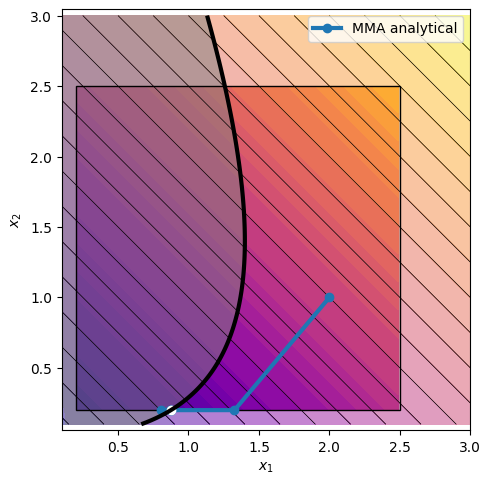

In [16]:
# Make a plot
plot_contours(
    a_grid,
    f(a_grid),
    paths={"MMA analytical": a},
    box=[a_lower, a_upper],
    opti=[a[-1][0], a[-1][1]],
    figsize=(5, 5),
)
plt.contour(a_1, a_2, g(a_grid), [0], colors="k", linewidths=3)
plt.contourf(a_1, a_2, g(a_grid), [0, 1], colors="gray", alpha=0.5)
plt.show()